In [72]:
%matplotlib widget

from functools import partial

import numpy as np
from scipy.signal import find_peaks
from scipy import optimize
import matplotlib.pyplot as plt

In [73]:
def sigmoid(x, thresh, steepness):
    return 1 / (1 + np.exp(-steepness * (x - thresh)))


def dxdt_v2(x, w, inj_excite, tau=20.0, tau_2=None, thresh=0.5, thresh_2=None,
            steepness=8.0, steepness_2=None):
    """Wilson-Cowan ODEs w/ distinct activation functions for two subgroups."""
    if tau_2 is None:
        tau_2 = tau
    if thresh_2 is None:
        thresh_2 = thresh
    if steepness_2 is None:
        steepness_2 = steepness
    
    inputs = (x @ w) + inj_excite
    n_dim = len(x)
    x_ = np.zeros((n_dim,))
    x_[:n_dim // 2] = (-x[:n_dim // 2] + sigmoid(inputs[:n_dim // 2], thresh,
                                                 steepness)) / tau
    x_[n_dim // 2:] = (-x[n_dim // 2:] + sigmoid(inputs[n_dim // 2:], thresh_2,
                                                 steepness_2)) / tau_2
    return x_


def rk4(t, x, dt, dxdt):

    # Calculate slopes
    k1, t_input_current = dxdt(t, x)
    k2, _ = dxdt(t + (dt / 2.), x + (k1 / 2.))
    k3, _ = dxdt(t + (dt / 2.), x + (k2 / 2.))
    k4, _ = dxdt(t + dt, x + k3)
    
    # Calculate new x and y
    x_next = x + (dt / 6) * (k1 + (2 * k2) + (2 * k3) + k4)
    t_next = t + dt
    
    return t_next, x_next, t_input_current


def plot_sim_dev(times, x, ax_1):
    colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:blue']
    # ax_1.plot(times, np.mean(x, axis=1), color=[0.2, 0.2, 0.2], alpha=1.0)
    # plot time course of unit spike rates
    for unit_idx in range(x.shape[1]):
        color = colors[unit_idx]
        ls = '-'
        if unit_idx >=2:
            ls = ':'
        x_traj = x[:, unit_idx]
        ax_1.plot(times, x_traj, color=color, ls=ls, alpha=1.0)
    # plot markers at avg event peaks
    x_avg = np.mean(x[:, :2], axis=1)
    peak_idxs, _ = find_peaks(x_avg)
    ax_1.scatter(times[peak_idxs], x_avg[peak_idxs], marker='_', color='k')


def sim_dev(dev, w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb, tau, tau_2,
            thresh, thresh_2, steepness, steepness_2, ipsirepr_inhib=0.75,
            rep_interval=100):
    """Simulate competitive inhibitory network under deviant drive.

    Parameters
    ----------
    dev : float

    w_ii : float
        Recurrent connection weight for diagonal elements (ith -> ith unit)
        of the connectivity matrix. This value should be >=0 since this
        neural mass shouldn't inhibit itself.
    w_ij : float
        Recurrent connection weight for interacting off-diagonal elements
        (ith -> jth unit s.t. i != j) of the connectivity matrix. This value
        should be <=0 to provide competive inhbition.
    fb : float
        Feedback scaling factor for cross-laminar w_ij terms.

    Returns
    -------
    times : 
    x : 
    inj_excite : 
    w : 
    """

    # integration params
    dt = 0.1  # ms
    burn_in = 100  # ms
    # sim time: try 600 and fix below for one extra trial after dev
    # tstop = burn_in + 12 * rep_interval  # ms
    tstop = burn_in + 7 * rep_interval  # ms
    times = np.arange(0, tstop + dt, dt)

    # network params
    # number of competing neural mass units per subgroup (i.e., representations
    # per layer)
    n_dim = 2
    # total units: multiply by two subgroups (e.g., layers)
    n_units = n_dim * 2
    x = np.zeros((len(times), n_units))

    # drive params
    baseline = 0.01
    # baseline = np.array([0.01, 0.01, 0.01, 0.01])
    inj_delta = 0.10  # difference in drive magnitude between representations

    # set initial state
    x[0, :] = 0.0

    # repetative injected excitation (exogenous drive): half-period of square
    # wave at 20 ms, lasting 20 ms
    inj_excite = np.zeros_like(x) + baseline
    # calculate decendng offset values for each representation (dimension) that
    # are inj_delta apart, zero-centered
    inj_offsets = np.linspace(inj_delta, 0, n_dim)
    inj_offsets -= inj_offsets.mean()

    # define network connectivity weight matrix
    # setup to accomodate a network of arbitrary # of representations
    # (dimensions), but should look something like this for n_dim=2:
    # w = np.array([[w_ii, w_ij, 0, 0],
    #               [w_ij, w_ii, 0, 0],
    #               [w_fb, w_fb / 3, w_ii_l2, w_ij_l2],
    #               [w_fb / 3, w_fb, w_ij_l2, w_ii_l2]])
    w = np.zeros((n_units, n_units))

    # 1st subgroup (layer)
    # diagnal excitatory weights
    w[:n_dim, :n_dim] += w_ii * np.eye(n_dim)
    # off-diagnal inhibitory weights
    w[:n_dim, :n_dim] += w_ij * (np.ones((n_dim, n_dim)) - np.eye(n_dim))

    # 2nd subgroup (layer)
    # diagnal excitatory weights
    w[n_dim:, n_dim:] += w_ii_l2 * np.eye(n_dim)
    # off-diagnal inhibitory weights
    w[n_dim:, n_dim:] += w_ij_l2 * (np.ones((n_dim, n_dim)) -
                                    np.eye(n_dim))

    # inhibition from 2nd subgroup -> 1st subgroup
    # diagnal ipsi-representation inhibitory weights
    contrarepr_inhib = 1 - ipsirepr_inhib  # try 1/2 or 1/3
    w[n_dim:, :n_dim] += (w_fb * ipsirepr_inhib) * np.eye(n_dim)
    # off-diagnal contra-representation inhibitory weights
    w[n_dim:, :n_dim] += ((w_fb * contrarepr_inhib) *
                          (np.ones((n_dim, n_dim)) - np.eye(n_dim)))

    def dxdt_v2_w_injection(t, x,
                            w=w, tau=tau, tau_2=tau_2, thresh=thresh,
                            thresh_2=thresh_2, steepness=steepness,
                            steepness_2=steepness_2, burn_in=burn_in,
                            rep_interval=rep_interval, tstop=tstop,
                            n_units=n_units, n_dim=n_dim,
                            inj_offsets=inj_offsets, baseline=baseline,
                            dev=dev):
        """Complete ODE system including time-dependent injected excitation.

        Note that this is needed to allow the RK4 method to evalute the system
        at times in-between time steps at which the injected current
        hasn't yet been explicitly defined.
        """
        # determine current 'stimulus' repetition onset time
        rep_tstart = burn_in + (np.abs(t - burn_in) // rep_interval) * rep_interval
        # if within the time bounds of afferent drive for the evoked response,
        # apply injected excitation that surpasses baseline drive
        inj_excite = np.zeros((n_units,))
        if t >= rep_tstart + 20.0 and t < rep_tstart + 40.0:
            for unit_idx in range(n_dim):
                inj_excite[unit_idx::n_dim] = 0.5 + inj_offsets[unit_idx]

            # on final trial, reduce injected excitation (exogneous drive)
            # if rep_tstart == tstop - rep_interval:
            if rep_tstart >= burn_in + (2 + dev) * rep_interval:
            # if rep_tstart >= burn_in + (3 * rep_interval) and rep_tstart < burn_in + (6 * rep_interval):
                # inj_excite *= (1 + dev)
                for unit_idx in range(n_dim):
                    inj_excite[unit_idx::n_dim] = 0.5 - inj_offsets[unit_idx]
            # else:
            #     inj_excite *= (1 - dev)
        else:
            inj_excite = baseline

        return dxdt_v2(x, w, inj_excite,
                       tau=tau, tau_2=tau_2,
                       thresh=thresh, thresh_2=thresh_2,
                       steepness=steepness, steepness_2=steepness_2), inj_excite

    # forward-Euler
    # for t_idx, time in enumerate(times):
    #     if t_idx > 0:
            # dx = dxdt_v2(x[t_idx - 1, :], w, inj_excite[t_idx - 1, :],
            #              tau=tau, tau_2=tau_2,
            #              thresh=thresh, thresh_2=thresh_2,
            #              steepness=steepness, steepness_2=steepness_2) * dt
            # x[t_idx, :] = x[t_idx - 1, :] + dx

    # Runge-Kutta (RK) 4
    # NB: be sure to use pre-computed time values as time calculated
    # recursively contains too much rounding error
    for t_idx, time in enumerate(times[:-1]):
        _time, x[t_idx + 1, :], inj_excite[t_idx, :] = rk4(time, x[t_idx, :].copy(),
                                                           dt, dxdt_v2_w_injection)

    return times, x, inj_excite, w

In [74]:
def cost_func(neg_dev_peak, pos_dev_peak, std_peak):
    # kinda works but doesn't officially converge
    # return (std_peak - (neg_dev_peak + pos_dev_peak) / 2) / np.abs(neg_dev_peak - pos_dev_peak)
    # most effective!!
    neg_dev_diff = neg_dev_peak - std_peak
    pos_dev_diff = pos_dev_peak - std_peak
    if neg_dev_diff < 0 and pos_dev_diff < 0:
        # discourage the case where both pos and neg deviants produce
        # decreasing responses
        return neg_dev_diff * pos_dev_diff
    else:
        # optimizer will spend most of its time here trying to minimize
        return -neg_dev_diff * pos_dev_diff
    # kinda works with Nelder-Mead, but doesn't officially converge
    # return std_peak - np.min([neg_dev_peak, pos_dev_peak])


def cost_func_02(neg_dev_peak, pos_dev_peak, std_peak):
    neg_dev_diff = neg_dev_peak - std_peak
    pos_dev_diff = pos_dev_peak - std_peak
    return np.log(neg_dev_diff ** 2) + np.log(pos_dev_diff ** 2)


def get_final_response_peak(x, times, t_win, n_dim_units=2):
    t_idxs = np.nonzero(np.logical_and(times >= t_win[0], times < t_win[1]))[0]
    x_avg = np.mean(x[t_idxs, :n_dim_units], axis=1)
    peak = np.max(x_avg)
    return peak


def validate_responses(x, inj_excite):
    """Test that none of the units enter the high attractor basin."""
    # NB: only one unit's inj_excite is needed since the rise and drop times
    # are the same across units
    inj_traj = inj_excite[:, 0]
    di = np.diff(inj_traj, axis=0)
    # compensate for sample lost during diff calculation
    drop_idxs = np.nonzero(di < 0)[0] + 1
    rise_idxs = np.nonzero(di > 0)[0] + 1
    drop_win_length = rise_idxs[1] - drop_idxs[0]

    runaway_excite = False
    for drop_idx in drop_idxs:
        x_drop = x[drop_idx, :]
        x_post_drop = x[drop_idx:drop_idx + drop_win_length, :]
        print(drop_idx, drop_idx + drop_win_length)
        runaway_excite = bool(np.sum((x_post_drop - x_drop) > 0))
        if runaway_excite:
            return False
    return True


def sim_and_eval_cost(params_vary, plot_sims=False, plot_sims_wo_fb=False):
    """Call this function for minimization."""
    # const params
    dev_mag = 0.2
    tau = 20
    tau_2 = 20
    thresh = 0.5
    thresh_2 = 0.5
    steepness = 8
    steepness_2 = 15
    ipsirepr_inhib = 0.75
    rep_interval = 100
    # super const params (these are hardcoded in sim_dev but relevant here)
    n_dim_units = 2
    burn_in = 100

    # varied params
    w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb = params_vary

    if plot_sims is True:
        gridspec = {'width_ratios': [1, 1, 1, 1], 'height_ratios': [3, 1]}
        fig, axes = plt.subplots(2, 4, sharex='col', sharey='row',
                                 gridspec_kw=gridspec, figsize=(6, 4))
        if plot_sims_wo_fb is True:
            # plot without cross-group inhibition
            w_fb = 0.0

    # run 3 sims: neg dev, pos dev, and no dev for control
    peaks = list()
    for idx, dev_sign in enumerate([-1, 0, 1, 2]):
        # dev = dev_sign * dev_mag
        dev = dev_sign
        times, x, inj_excite, _w = sim_dev(dev=dev,
                                           w_ii=w_ii,
                                           w_ij=w_ij,
                                           w_ii_l2=w_ii_l2,
                                           w_ij_l2=w_ij_l2,
                                           w_fb=w_fb,
                                           tau=tau,
                                           tau_2=tau_2,
                                           thresh=thresh,
                                           thresh_2=thresh_2,
                                           steepness=steepness,
                                           steepness_2=steepness_2,
                                           ipsirepr_inhib=ipsirepr_inhib,
                                           rep_interval=rep_interval)
        
        tstop = times[-1]
        final_t_win = [tstop - rep_interval, tstop]
        final_peak = get_final_response_peak(x, times, final_t_win,
                                             n_dim_units=n_dim_units)
        peaks.append(final_peak)

        # valid_trial = validate_responses(x, inj_excite)
        # if not valid_trial:
        #     print('Warning: simulated an invalid trail with runaway '
        #           'excitation!!!')

        if plot_sims is True:
            # shift time values to reflect burn_in/baseline
            times -= burn_in
            plot_sim_dev(times, x[:, :2], axes[0, idx])
            colors = ['tab:red', 'tab:blue', 'tab:green']
            for unit_idx in range(inj_excite.shape[1] // 2):
                inj_excite_traj = inj_excite[:, unit_idx]
                axes[1, idx].plot(times, inj_excite_traj,
                                  color=colors[unit_idx])
                axes[1, idx].set_xticks(np.arange(0, tstop - burn_in + 1,
                                                  rep_interval))
    
    if plot_sims is True:
        return fig

    return cost_func(peaks[0], peaks[2], peaks[1])

In [5]:
# set initial param values + bounds that will get varied during optimization
x0 = [0.9, -0.9, 0.2, -0.4, -0.8]
bounds = [(0.1, 1.0),
          (-1.1, -0.2),
          (0.1, 1.0),
          (-1.1, -0.2),
          (-1.0, -0.1)]

sol = optimize.minimize(sim_and_eval_cost, x0, bounds=bounds,
                        method='L-BFGS-B', options={'maxiter': 200,
                                                    'disp': True})  # 'nelder-mead'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01527D-03    |proj g|=  1.11677D-02

At iterate    1    f=  8.66233D-04    |proj g|=  1.05189D-02

At iterate    2    f=  1.06040D-04    |proj g|=  1.36024D-03

At iterate    3    f= -3.57869D-05    |proj g|=  1.27395D-03

At iterate    4    f= -2.99478D-04    |proj g|=  1.03918D-03
  ys=-1.024E-04  -gs= 2.048E-04 BFGS update SKIPPED

At iterate    5    f= -3.09241D-04    |proj g|=  1.49763D-04

At iterate    6    f= -4.28515D-04    |proj g|=  4.40561D-04

At iterate    7    f= -4.28987D-04    |proj g|=  3.10637D-04

At iterate    8    f= -4.30632D-04    |proj g|=  1.39667D-05

At iterate    9    f= -4.30635D-04    |proj g|=  4.67140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

[ 1.         -0.33840608  0.2270948  -0.2        -1.        ] CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


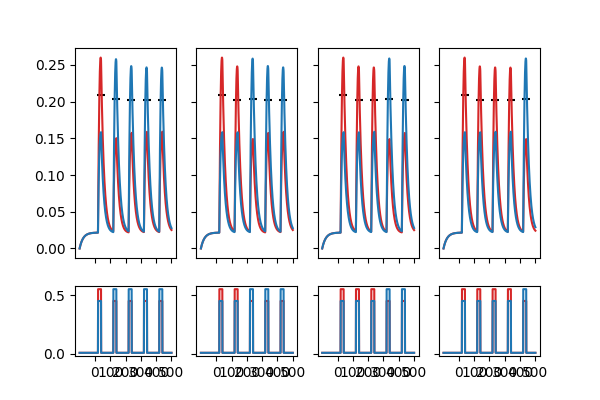

In [27]:
print(sol.x, sol.message)
fig_1 = sim_and_eval_cost(sol.x, plot_sims=True, plot_sims_wo_fb=False)

In [17]:
fig_1.savefig('simple_model_example.pdf')

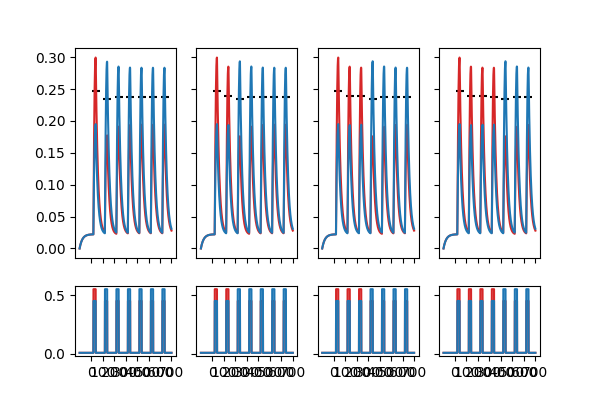

In [79]:
# investigate opt results
# x_ = [1., -0.2, 0.51138264, -0.2, -0.86530887]
x_ = [1.4, -0.33840608, 0.2270948, -0.2, -1.]  # diverging
# x_ = [1.0, -0.43840608, 0.2270948, -0.8, -1.]  # converging
fig_1 = sim_and_eval_cost(x_, plot_sims=True, plot_sims_wo_fb=False)
# fig_2 = sim_and_eval_cost(x_, plot_sims=True, plot_sims_wo_fb=True)

In [78]:
fig_1.savefig('simple_model_repr_dev_divergence.pdf')

In [18]:
# sweep of different model configuration and optimize at each step
n_samp = 5
ipsirepr_inhib_sweep = np.linspace(0, 1, n_samp)
x_ = np.zeros((n_samp, 5))

for sweep_idx, ipsirepr_inhib in enumerate(ipsirepr_inhib_sweep):

    def sim_and_eval_cost_tmp(params_vary, ipsirepr_inhib=ipsirepr_inhib):
        """Temp. sim+cost function to minimize within a nested param sweep."""
        # const params
        dev_mag = 0.2
        tau = 20
        tau_2 = 20
        thresh = 0.5
        thresh_2 = 0.5
        steepness = 8
        steepness_2 = 15
        rep_interval = 100
        # super const params (these are hardcoded in sim_dev but relevant here)
        n_dim_units = 2
        burn_in = 100
        tstop = 500
        final_rep_t_win = [tstop - rep_interval, tstop]

        # varied params
        w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb = params_vary

        # run 3 sims: neg dev, pos dev, and no dev for control
        peaks = list()
        for idx, dev_sign in enumerate([-1, 1, 0]):
            dev = dev_sign * dev_mag
            times, x, _inj_excite, _w = sim_dev(dev=dev,
                                                w_ii=w_ii,
                                                w_ij=w_ij,
                                                w_ii_l2=w_ii_l2,
                                                w_ij_l2=w_ij_l2,
                                                w_fb=w_fb,
                                                tau=tau,
                                                tau_2=tau_2,
                                                thresh=thresh,
                                                thresh_2=thresh_2,
                                                steepness=steepness,
                                                steepness_2=steepness_2,
                                                ipsirepr_inhib=ipsirepr_inhib,
                                                rep_interval=rep_interval)
            peak = get_final_response_peak(x, times, final_rep_t_win,
                                           n_dim_units=n_dim_units)
            peaks.append(peak)

        return cost_func(peaks[0], peaks[1], peaks[2])

    x0 = [0.9, -0.9, 0.2, -0.4, -0.8]
    bounds = [(0.1, 1.0),
              (-1.0, -0.2),
              (0.1, 1.0),
              (-1.0, -0.2),
              (-1.0, -0.1)]

    sol = optimize.minimize(sim_and_eval_cost_tmp, x0, bounds=bounds,
                            method='L-BFGS-B', options={'maxiter': 200})
    x_[sweep_idx, :] = sol.x
    print(sol.message)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


-0.004193698966283187
4.3629445651288606e-12


/tmp/ipykernel_7731/1870759108.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 3, sharex='col', sharey='row',


-0.0017492310987752358
-0.0017507938120618813
-0.0036312806130860114


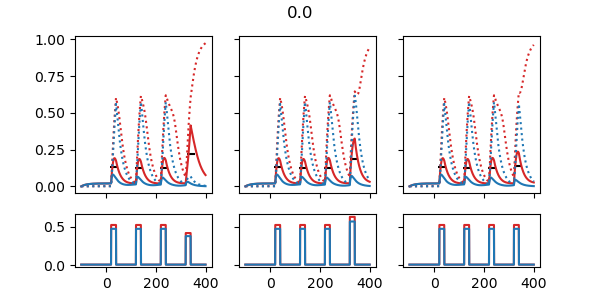

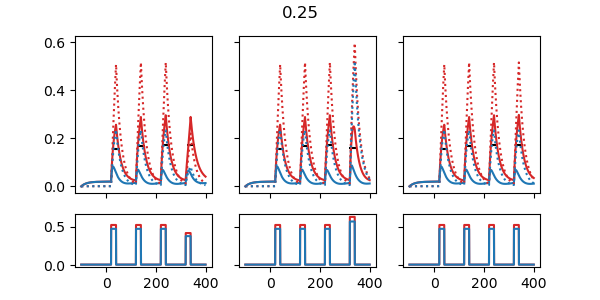

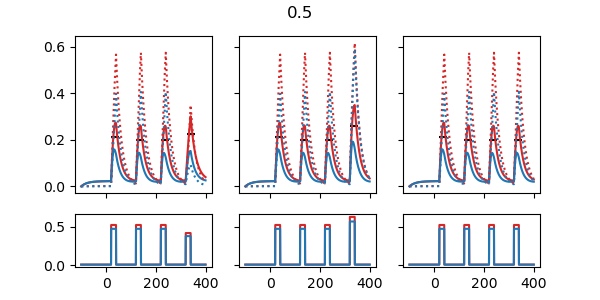

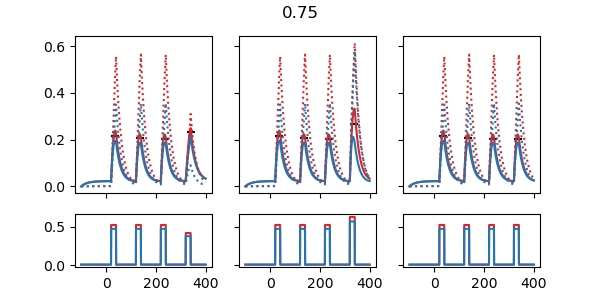

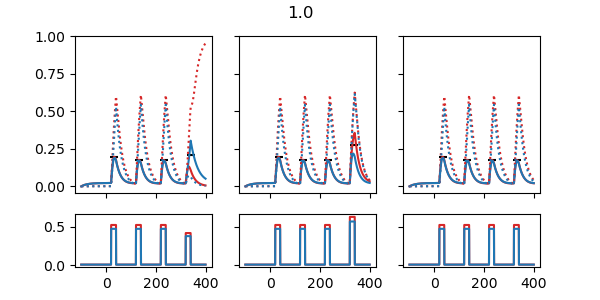

In [20]:

def plot_sims(params_vary, ipsirepr_inhib, plot_sims_wo_fb=False):
    """Call this function for minimization."""
    # const params
    dev_mag = 0.2
    tau = 20
    tau_2 = 20
    thresh = 0.5
    thresh_2 = 0.5
    steepness = 8
    steepness_2 = 15
    rep_interval = 100
    # super const params (these are hardcoded in sim_dev but relevant here)
    n_dim_units = 2
    burn_in = 100
    tstop = 500
    final_rep_t_win = [tstop - rep_interval, tstop]

    # varied params
    w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb = params_vary

    gridspec = {'width_ratios': [1, 1, 1], 'height_ratios': [3, 1]}
    fig, axes = plt.subplots(2, 3, sharex='col', sharey='row',
                             gridspec_kw=gridspec, figsize=(6, 3))
    if plot_sims_wo_fb is True:
        # plot without cross-group inhibition
        w_fb = 0.0

    # run 3 sims: neg dev, pos dev, and no dev for control
    peaks = list()
    for idx, dev_sign in enumerate([-1, 1, 0]):
        dev = dev_sign * dev_mag
        times, x, inj_excite, _w = sim_dev(dev=dev,
                                            w_ii=w_ii,
                                            w_ij=w_ij,
                                            w_ii_l2=w_ii_l2,
                                            w_ij_l2=w_ij_l2,
                                            w_fb=w_fb,
                                            tau=tau,
                                            tau_2=tau_2,
                                            thresh=thresh,
                                            thresh_2=thresh_2,
                                            steepness=steepness,
                                            steepness_2=steepness_2,
                                            ipsirepr_inhib=ipsirepr_inhib,
                                            rep_interval=rep_interval)
        peak = get_final_response_peak(x, times, final_rep_t_win,
                                       n_dim_units=n_dim_units)
        peaks.append(peak)

        # shift time values to reflect burn_in/baseline
        times -= burn_in
        plot_sim_dev(times, x[:, :], axes[0, idx])
        colors = ['tab:red', 'tab:blue']
        for unit_idx in range(inj_excite.shape[1] // 2):
            inj_excite_traj = inj_excite[:, unit_idx]
            axes[1, idx].plot(times, inj_excite_traj, color=colors[unit_idx])
    
    return cost_func(peaks[0], peaks[1], peaks[2]), fig




for sweep_idx, ipsirepr_inhib in enumerate(ipsirepr_inhib_sweep):
    cost, fig = plot_sims(x_[sweep_idx, :], ipsirepr_inhib)
    print(cost)
    fig.suptitle(f'{ipsirepr_inhib}')

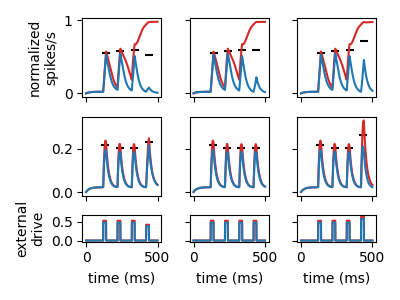

In [6]:
def plot_sim_dev(times, x, ax_1):
    colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:blue']
    # ax_1.plot(times, np.mean(x, axis=1), color=[0.2, 0.2, 0.2], alpha=1.0)
    # plot time course of unit spike rates
    for unit_idx in range(x.shape[1]):
        color = colors[unit_idx]
        ls = '-'
        if unit_idx >=2:
            ls = ':'
        x_traj = x[:, unit_idx]
        ax_1.plot(times, x_traj, color=color, ls=ls, alpha=1.0)
    # plot markers at avg event peaks
    x_avg = np.mean(x[:, :2], axis=1)
    peak_idxs, _ = find_peaks(x_avg)
    ax_1.scatter(times[peak_idxs], x_avg[peak_idxs], marker='_', color='k')


# for final figures!!!!

dev = 0.2  # change in proportion of original injected excitation

w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb = [1., -0.2, 0.51138264, -0.2, -0.86530887]

tau = 20
tau_2 = 20
thresh = 0.5
thresh_2 = 0.5
steepness = 8
steepness_2 = 15

# setup figure
gridspec = {'width_ratios': [1, 1, 1], 'height_ratios': [3, 3, 1]}
fig, axes = plt.subplots(3, 3, sharex='col', sharey='row',
                         gridspec_kw=gridspec, figsize=(4, 3))

# -DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=-dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2,)
plot_sim_dev(times, x[:, :2], axes[0, 0])  # only plot first subgroup

# 0 DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 1])  # only plot first subgroup

# +DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 2])  # only plot first subgroup

# -DEV; with L6
times, x, inj_excite, _ = sim_dev(dev=-dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[1, 0])  # now plot both subgroups
# plot time course for injected excitation
colors = ['tab:red', 'tab:blue']
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 0].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

# 0 DEV; with L6
times, x, inj_excite, w = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[1, 1])  # now plot both subgroups
# plot time course for injected excitation
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 1].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

# +DEV; with L6
times, x, inj_excite, w = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[1, 2])  # now plot both subgroups
# plot time course for injected excitation
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 2].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

axes[0, 0].set_ylabel('normalized\nspikes/s')
axes[2, 0].set_ylabel('external\ndrive')
axes[2, 0].set_xlabel('time (ms)')
axes[2, 1].set_xlabel('time (ms)')
axes[2, 2].set_xlabel('time (ms)')
fig.tight_layout()
plt.show()

In [7]:
fig.savefig('simple_model_example_detailed.pdf')

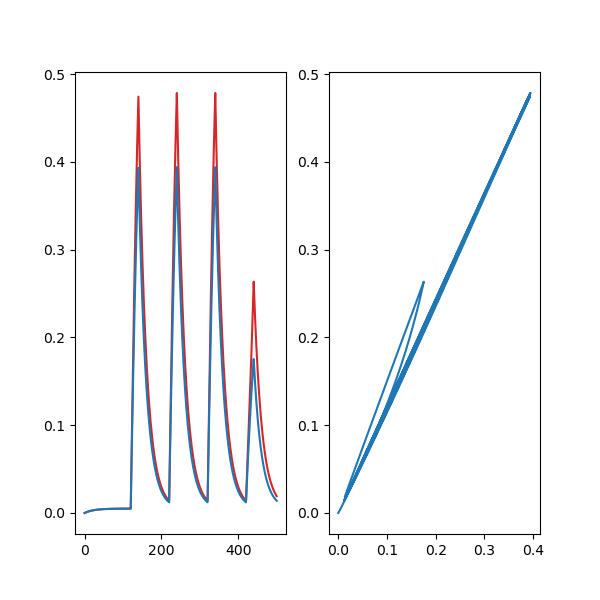

In [23]:
inhib = -1 * (x @ (w * (np.ones_like(w) - np.eye(w.shape[0]))))

inhib_red = inhib[:, 0]
inhib_blue = inhib[:, 0]

colors = ['tab:red', 'tab:blue']
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].plot(times, inhib[:, 0], color=colors[0])
axes[0].plot(times, inhib[:, 1], color=colors[1])
axes[1].plot(inhib[:, 1], inhib[:, 0])
plt.show()